# MCMC

## Algoritmo de Metropolis

El objetivo del algoritmo de Metropolis es generar una muestra $\theta_1,\ldots,\theta_s$ de una distribución. En el contexto bayesiano nos interesa que esa muestra sea de una distribución posterior. La idea del algoritmo de Metropolis es la siguiente:

1. Queremos una colección de valores $\{ \theta_1,...,\theta_s\}$ cuya distribución empírica aproxima a la distribución de $\theta|y$.
2. Suponga que ya tenemos una colección de valores $\{ \theta_1,...,\theta_s\}$, y queremos determinar si podemos agregar un nuevo valor, $\theta_{*}$.
  1. Si $p(\theta_*|y) > p(\theta_s|y)$, entonces $\theta_*$ es más probable que $\theta_s$, por lo que queremos tener más valores $\theta_*$ que $\theta_s$. Por lo que aceptamos el nuevo valor, i.e $\theta_{s+1} = \theta_*$.
  2. Si $p(\theta_*|y) < p(\theta_s|y)$, por el argumento anterior podríamos aceptar $\theta_*$ o rechazarlo. Aceptamos $\theta_*$ con probabilidad $\frac{p(\theta_*|y)}{p(\theta_s|y)}$.

Note que el cociente $\frac{p(\theta_*|y)}{p(\theta_s|y)}$ puede ser calculado aún cuando no podamos calcular $p(\theta|y)$:
$$
r = \frac{p(\theta_*|y)}{p(\theta_s|y)} = \frac{p(y|\theta_*)p(\theta_*)}{p(y)}\frac{p(y)}{p(y|\theta_s)p(\theta_s)} = \frac{p(y|\theta_*)p(\theta_*)}{p(y|\theta_s)p(\theta_s)}
$$

En el algoritmo de Metropolis se muestrea el valor $\theta_*$ cercano a $\theta_s$ usando una distribución propuesta que sea simétrica, $J(\theta_* | \theta_s)$, con varianza adecuada.

Lo anterior se precisa en el siguiente algoritmo.

---
__Algoritmo (de Metropolis):__

Para generar una colección de valores, $\{ \theta_1,\ldots,\theta_s \}$:
1. Dado $\theta_s$, generar $\theta_* \sim J(\theta|\theta_s)$.
2. Calcular la tasa de aceptación
$$
r = \frac{p(\theta_*|y)}{p(\theta_s | y)} = \frac{p(y|\theta_*)p(\theta_*)}{p(y|\theta_s)p(\theta_s)}
$$
3. Hacer
$$
\theta_{s+1} = \begin{cases} \theta_* &\text{ con probabilidad }\min{(r,1)} \\ \theta_s &\text{ con probabilidad }1-\min{(r,1)} \end{cases}
$$

Obs 1: El paso 3 es equivalente a generar $u \sim U(0,1)$ y hacer $\theta_{s+1}=\theta_*$ si $u < r$ o hacer $\theta_{s+1}=\theta_s$ en otro caso.

Obs 2: Para inicializar el algoritmo es necesario dar $\theta_1$.

Obs 3: Calcular $r$ podría ser numéricamente inestable, por lo que conviene hacer los cálculos en escala logarítmica.

---

El resultado de repetir el algoritmo de Metropolis es una sucesión __dependiente__ de valores $\{\theta_1, \theta_2,\ldots\}$.
Además, como $\theta_{s+1}$ solo depende de $\theta_s$, entonces la distribución condicional de $\theta_{s+1}$ dado $\{ \theta_1,.\ldots,\theta_s\}$ solo depende de $\theta_s$, por lo que la sucesión resultante es una cadena de Markov.
Por otro lado, para $s$ suficientemente grande, la distribución de $\theta_s$ converge a la distribución de $\theta | y$. Para cualquier $\theta_a \in sop(\theta)$,

$$
\lim_{s\to∞} \frac{|\{\theta\in\{\theta_1,\ldots,\theta_s\}: \theta <\theta_a\}|}{s} = \mathbb{P}(\theta < \theta_a | y)
$$

Como el valor $\theta_1$ no necesariamente está en una región de alta densidad de $\theta|y$, los primeros valores generados por el algoritmo de Metropolis podrían no seguir la distribución deseada (i.e la distribución estacionaria de la cadena que coincide con la posterior). Para evitar considerar valores de $\theta$ no deseados, se suele correr el algoritmo una cantidad fija de iteraciones, y apartir de una iteración, $b$, volver a ejecutar el algoritmo para generar los valores $\{ \theta_{b+1}, \ldots, \theta_{b+s}\}$.
Usando el algorimo de Metropolis siempre podemos movernos de zonas de baja densidad (que ocurren durante las primeras iteraciones del algoritmo) a zonas de alta densidad (que se alcanza cuando la cadena alcanza la estacionariedad).

### Ejemplo
Considere una muestra $y_1,\ldots, y_n \sim \mathcal{N}(\theta, \sigma^2)$ con distribución inicial $\theta \sim \mathcal{N}(\mu, \tau^2)$. Queremos generar una colección de valores que sigan la distribución posterior, $\theta | y \sim \mathcal{N}(\mu_n, \tau^2_n)$.

__Sol__

Considere $\sigma^2 = 1, \tau^2 = 10, \mu = 5, n=10$ con $y=(8.3, 8.9, 10.9, 10, 10.6, 10.1, 10.1,  8.8,  8.9, 10.2)$.

Proponemos $J(\theta | \theta_s) = \mathcal{N}(\theta_s, \delta^2)$.

La tasa de aceptación es
$$
r =  \frac{p(y|\theta_*)p(\theta_*)}{p(y|\theta_s)p(\theta_s)} = \frac{\left(\prod_{i=1}^{n} \frac{1}{\sqrt{2\pi\sigma^2}} e^{- \frac{(y_i -\theta_*)^2}{2\sigma^2}}\right) \frac{1}{\sqrt{2\pi \tau^2}} e^{-\frac{(\theta_* -\mu)^2}{2\tau^2}} }{\left(\prod_{i=1}^{n} \frac{1}{\sqrt{2\pi\sigma^2}} e^{- \frac{(y_i -\theta_s)^2}{2\sigma^2}}\right) \frac{1}{\sqrt{2\pi \tau^2}} e^{-\frac{(\theta_s -\mu)^2}{2\tau^2}}}
$$

In [ ]:
import numpy as np
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt

In [ ]:
class Metropolis(ABC):
  def __init__(self, f_sampling, f_ini, sample):
    self._f_sampling = f_sampling
    self._f_ini = f_ini
    self._sample = sample

  @abstractmethod
  def sample_from_J(self, theta_s, delta) -> float:
    pass

  def __r_log(self, theta_star, theta_s):
    log_r = np.sum(np.log(self._f_sampling(self._sample, theta_star)))
    log_r -= np.sum(np.log(self._f_sampling(self._sample, theta_s)))
    log_r += self._f_ini(theta_star) - self._f_ini(theta_s)
    return log_r

  def run(self, s, b, delta, theta_1):
    chain = []
    chain.append(theta_1)

    while len(chain) < s + b:
      theta_s = chain[-1]
      theta_star = self.sample_from_J(theta_s, delta)
      log_r = self.__r_log(theta_star, theta_s)
      u = np.random.uniform(0, 1)
      if np.log(u) < log_r:
        chain.append(theta_star)

    return chain[b:]


In [ ]:
class NormalMetropolis(Metropolis):
  def __init__(self, f_sampling, f_ini, sample):
    super().__init__(f_sampling, f_ini, sample)

  def sample_from_J(self, theta_s, delta) -> float:
    theta_star = np.random.normal(theta_s, delta)
    return theta_star


def f_samp(y_i, theta):
  sigma2 = 1

  f = 1 / (np.sqrt(2 * np.pi * sigma2))
  f *= np.exp(-((y_i - theta)**2) / (2*sigma2))

  return f

def f_ini(theta):
  tau2 = 10
  mu = 5

  f = 1 / (np.sqrt(2 * np.pi * tau2))
  f *= np.exp(-((theta - mu)**2) / (2*tau2))

  return f

In [ ]:
sample = np.array([8.3,8.9,10.9,10,10.6,10.1,10.1,8.8,8.9,10.2])
normal_metropolis = NormalMetropolis(f_samp, f_ini, sample)

<ipython-input-139-d2c0b72ce62c>:12: RuntimeWarning: divide by zero encountered in log
  log_r = np.sum(np.log(self._f_sampling(self._sample, theta_star)))


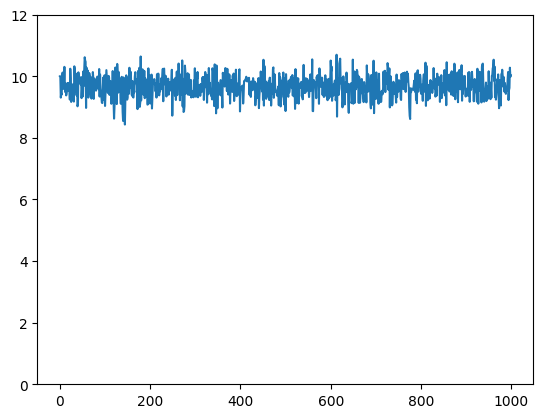

In [ ]:
chain = normal_metropolis.run(1000, 0, 15, 10)
plt.ylim([0,12])
plt.plot(chain);

### ¿Cómo saber si la cadena es "buena"?
- Calcular correlación (menor correlación, mejor cadena)
- Tamaño efectivo de la muestra

## Algoritmo de Metropolis-Hastings

## Algoritmo de Gibbs
